In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

def extract_centroids(mask, image=None, save_name=None, save_vis=False, vis_output_dir=None):
    if mask is None:
        return []

    if len(mask.shape) == 2:  
        mask_bgr = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    else:
        mask_bgr = mask

    hsv = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2HSV)

    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    contours, _ = cv2.findContours(mask_yellow, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    centroids = []  
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroids.append((cx, cy))

    if save_vis and image is not None and save_name is not None and vis_output_dir is not None:
        image_vis = image.copy()
        for cx, cy in centroids:
            cv2.circle(image_vis, (cx, cy), 5, (0, 0, 255), -1)
        output_path = os.path.join(vis_output_dir, save_name)
        cv2.imwrite(output_path, cv2.cvtColor(image_vis, cv2.COLOR_RGB2BGR))

    return centroids


/mnt/mydisk/CrescerAi/Bhumi/Segment_anything/IMAGES/2048_19456.jpg
/mnt/mydisk/CrescerAi/Bhumi/Segment_anything/MASKS/2048_19456.png


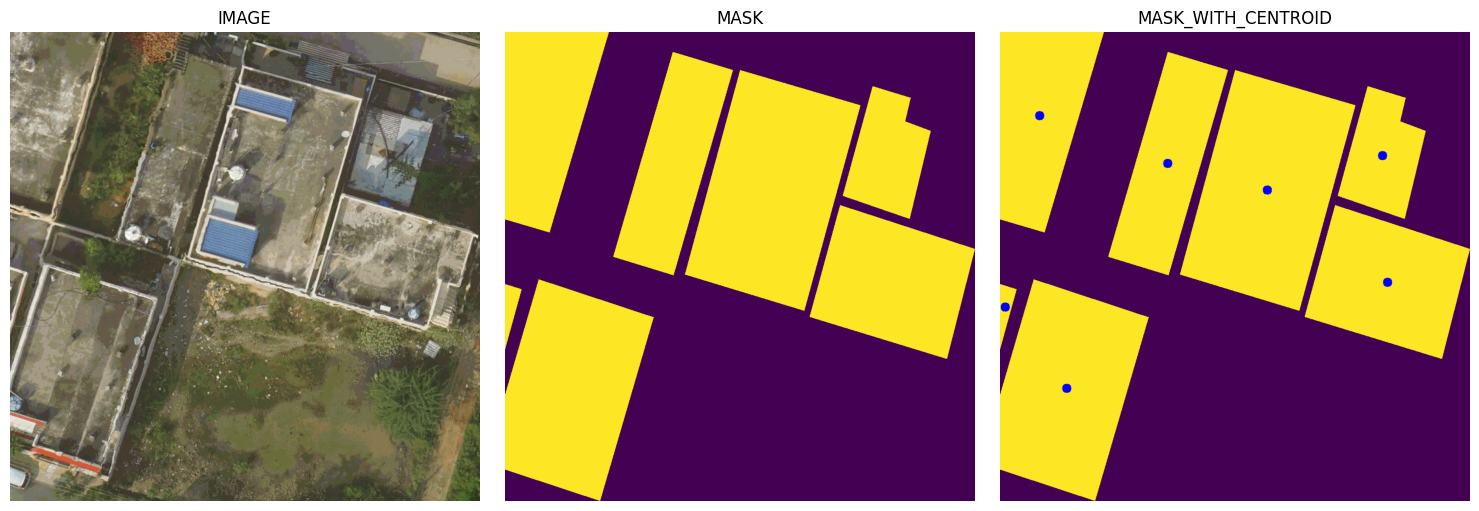

In [4]:

def visualize_raw_sample(true_image_dir, ground_truth_dir):
    image_files = sorted(list(Path(true_image_dir).glob("*.jpg"))) 
    mask_files = sorted(list(Path(ground_truth_dir).glob("*.png")))

    for image_path, mask_path in zip(image_files, mask_files):
        print(image_path)
        print(mask_path)
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(str(mask_path))
        mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        centroids = extract_centroids(mask)

        mask_vis = mask.copy()
        for cx, cy in centroids:
            cv2.circle(mask_vis, (cx, cy), 10, (255, 0, 0), -1)

        mask_vis_rgb = cv2.cvtColor(mask_vis, cv2.COLOR_BGR2RGB)

        ax[0].imshow(image)
        ax[0].set_title('IMAGE')
        ax[0].axis('off')

        ax[1].imshow(mask_rgb)
        ax[1].set_title('MASK')
        ax[1].axis('off')

        ax[2].imshow(mask_vis_rgb)
        ax[2].set_title('MASK_WITH_CENTROID')
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

# Call function with paths
true_image_dir = "/mnt/mydisk/CrescerAi/Bhumi/Segment_anything/IMAGES"
ground_truth_dir = "/mnt/mydisk/CrescerAi/Bhumi/Segment_anything/MASKS"
visualize_raw_sample(true_image_dir, ground_truth_dir)


In [5]:
def show_mask(mask, ax, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [6]:
import torch 
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def part_mask(original_mask, centroid):
    
    centroid = centroid.squeeze()
    
    if len(original_mask.shape) == 3:
        gray = cv2.cvtColor(original_mask, cv2.COLOR_RGB2GRAY)
    else:
        gray = original_mask.copy()
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    new_mask = np.zeros_like(gray)

    pt = (float(centroid[0]), float(centroid[1]))

    for cnt in contours:        
        if cv2.pointPolygonTest(cnt, pt, False) >= 0:
            cv2.drawContours(new_mask, [cnt], -1, 255, thickness=cv2.FILLED)
            break

    plt.figure(figsize=(8, 5))
    plt.imshow(new_mask, cmap='gray')
    plt.scatter(centroid[0], centroid[1], c='red', s=100, marker='x')
    plt.axis('off')
    plt.title('Isolated Patch with Centroid')
    plt.show()

    return new_mask


In [18]:
import numpy as np
import matplotlib.pyplot as plt

def compute_iou(org_mask, pred_mask):

    pred_mask = pred_mask.astype(bool)

    intersection = np.logical_and(org_mask, pred_mask)
    union = np.logical_or(org_mask, pred_mask)

    if union.sum() == 0:
        return 0.0
    
    return intersection.sum() / union.sum()


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List

def plot_kde(data: List[float]):

    plt.figure(figsize=(8,5))
    sns.kdeplot(data, linewidth=3, color="red", fill=True, alpha=0.25)


    sns.despine(left=True)
    plt.xlim(0, 2)
    plt.xlabel('')
    plt.yticks([])
    plt.tight_layout()

2048_19456
2048_19456


(1, 1024, 1024)


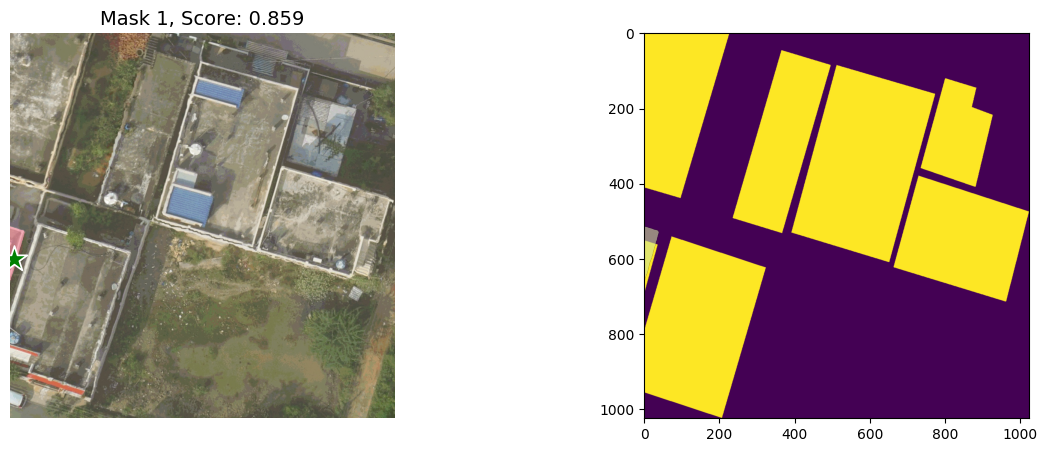

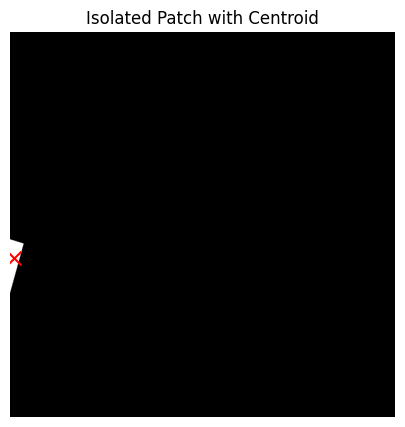

0.4467977811396873


<Figure size 640x480 with 0 Axes>

(1, 1024, 1024)


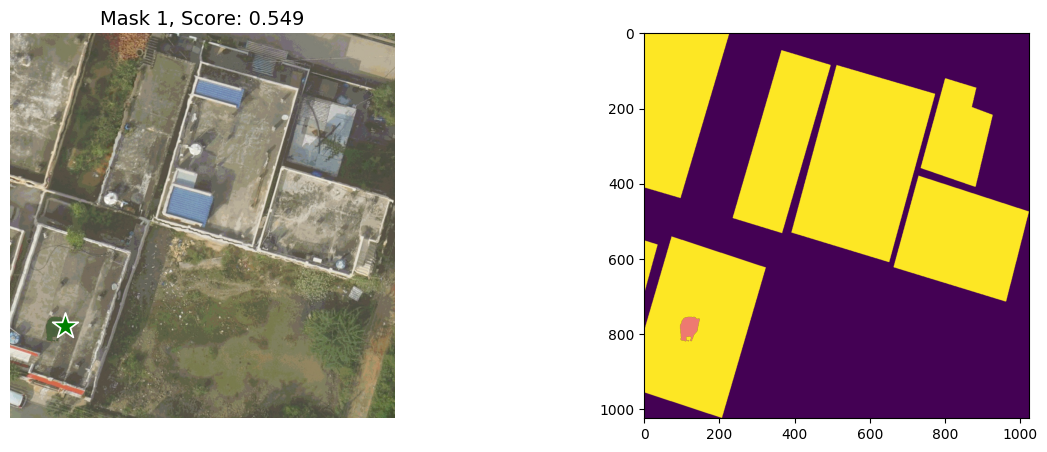

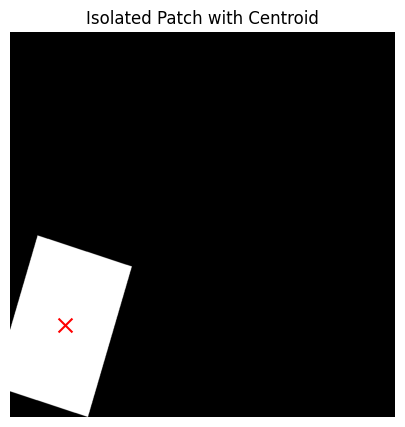

0.02319619094127701


<Figure size 640x480 with 0 Axes>

(1, 1024, 1024)


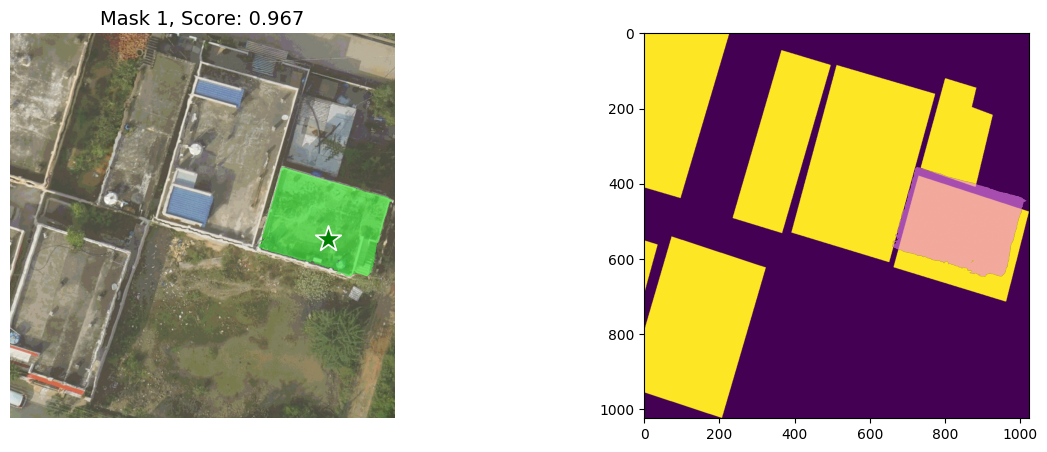

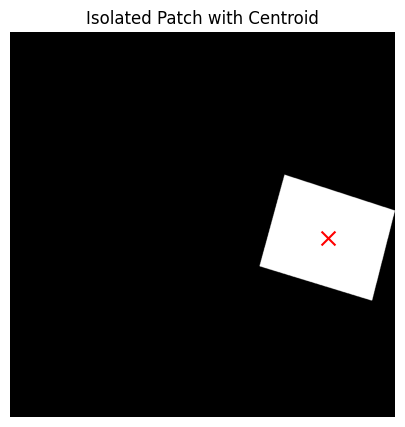

0.6496899760822499


<Figure size 640x480 with 0 Axes>

(1, 1024, 1024)


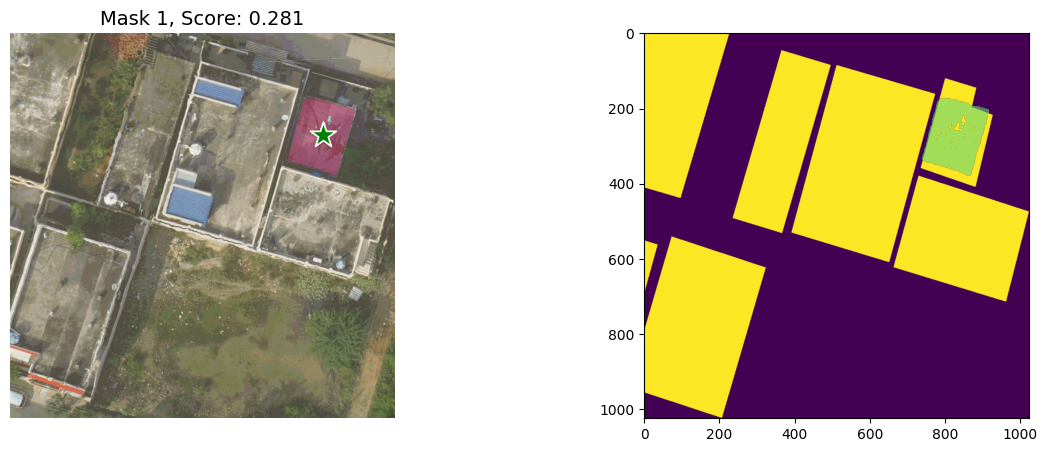

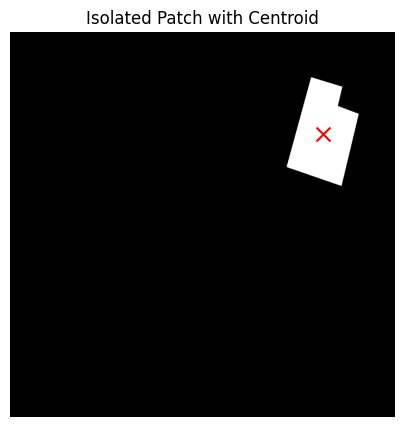

0.6555743243243243


<Figure size 640x480 with 0 Axes>

(1, 1024, 1024)


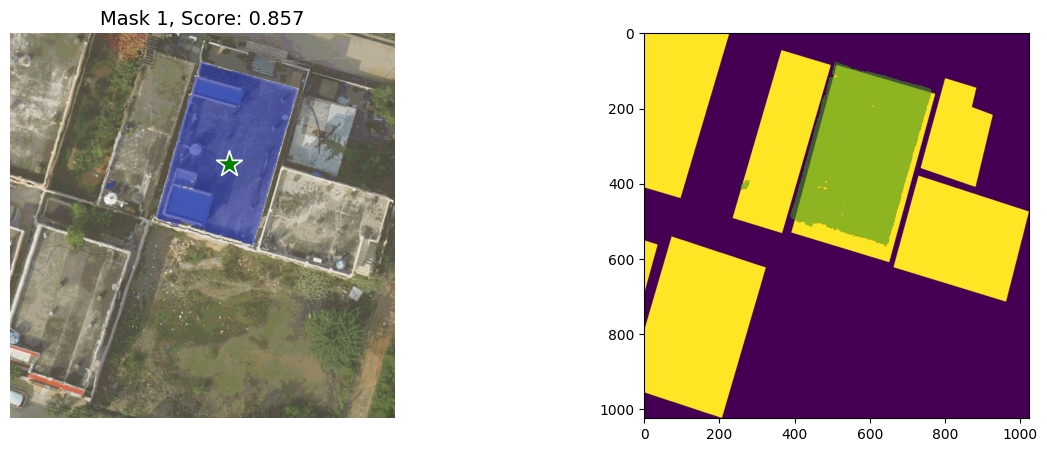

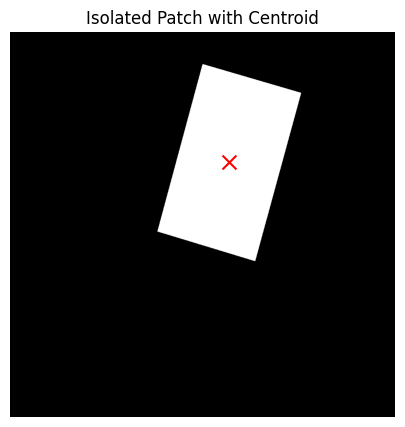

0.8128835043610192


<Figure size 640x480 with 0 Axes>

(1, 1024, 1024)


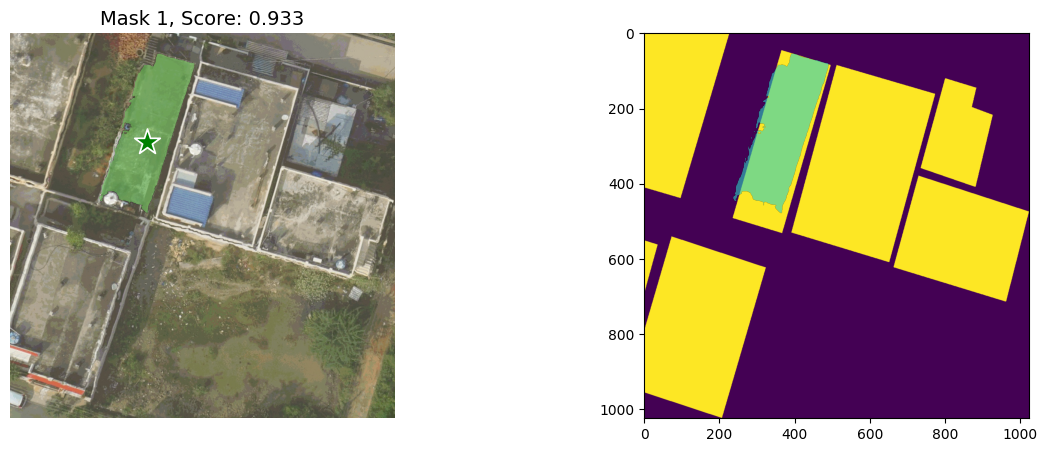

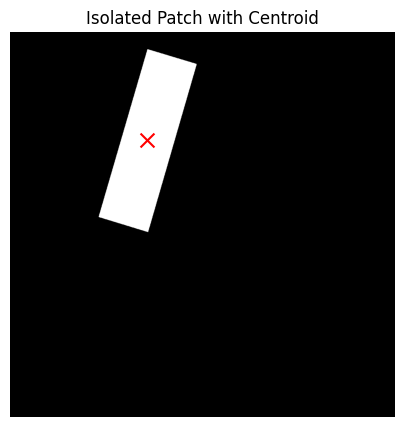

0.738442004630667


<Figure size 640x480 with 0 Axes>

(1, 1024, 1024)


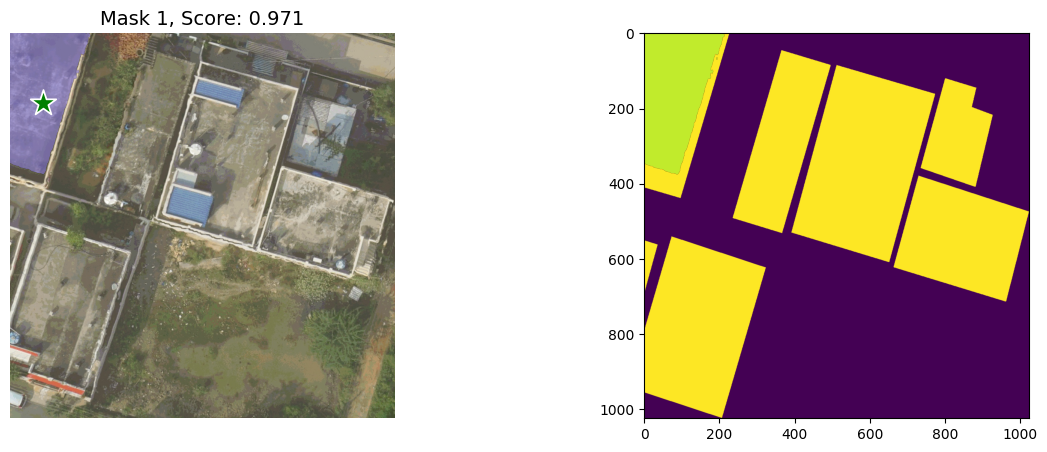

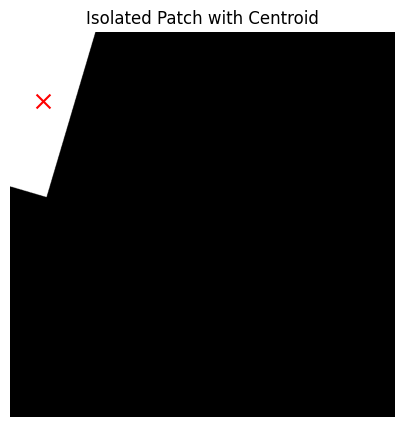

0.7982302912287735


<Figure size 640x480 with 0 Axes>

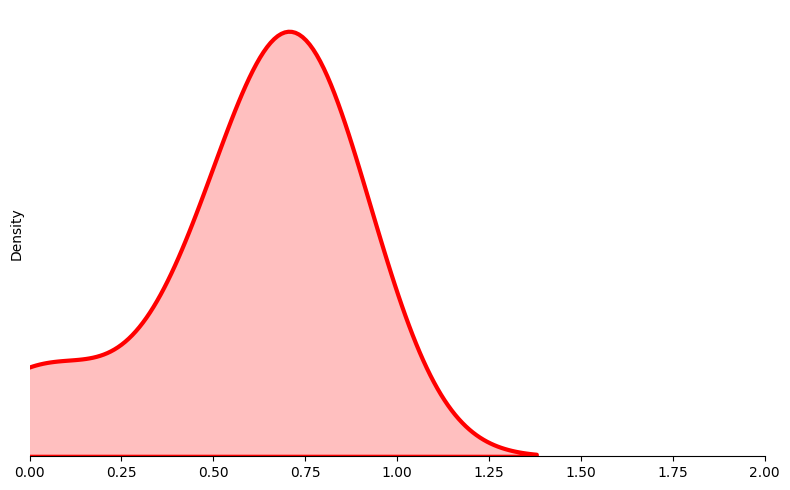

In [40]:
from segment_anything.utils.transforms import ResizeLongestSide
from pathlib import Path
import torch
import cv2

RESIZE_TRANSFORM = ResizeLongestSide(sam.image_encoder.img_size)


def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device)
    return image.permute(2, 0, 1).contiguous()

image_files = sorted(list(Path(true_image_dir).glob("*.jpg")))
mask_files = sorted(list(Path(ground_truth_dir).glob("*.png")))

sam_input_images = []
image_and_its_mask = {}


for image_path, mask_path in zip(image_files, mask_files):

    image_name = os.path.splitext(os.path.basename(image_path))[0]
    mask_name = os.path.splitext(os.path.basename(mask_path))[0]

    if image_name == mask_name:
        print(image_name)
        print(mask_name)
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        sam_input_image = prepare_image(image, RESIZE_TRANSFORM, device=sam.device)
        sam_input_images.append(sam_input_image)

        org_mask = cv2.imread(str(mask_path))
        org_mask_rgb = cv2.cvtColor(org_mask, cv2.COLOR_BGR2RGB)

        centroids = extract_centroids(org_mask)

        centroids_tensor = torch.tensor(centroids, device=sam.device)
        if centroids_tensor.ndim == 1:
            centroids_tensor = centroids_tensor.unsqueeze(0)

        sam_input_points = torch.tensor(centroids, dtype=torch.float, device=sam.device)
        resized_centroids = RESIZE_TRANSFORM.apply_coords_torch(centroids_tensor, original_size=image.shape[:2])

        predictor.set_image(image) 
        
        all_ious = []
        for idx , centroid_ in enumerate(centroids_tensor):
            input_label = np.ones(1, dtype=int)
            input_point = centroid_.cpu().numpy().reshape(1, 2)
            masks, scores, logits = predictor.predict(
                point_coords=input_point,
                point_labels=input_label,
                multimask_output=False,
            )

            print(masks.shape)
            fig, axs = plt.subplots(1, 2, figsize=(15, 5))

            pred_polys = []
            pred_vis_polys = []

            all_masks = []
            axs[0].imshow(image, alpha=0.9) 
            show_mask(masks[0], axs[0])
            show_points(input_point, input_label, axs[0])
            axs[0].set_title(f"Mask {1}, Score: {scores[0]:.3f}", fontsize=14)
            axs[0].axis('off')

            axs[1].imshow(org_mask_rgb)
            show_mask(masks , axs[1])


            original_mask_gt = part_mask(original_mask=org_mask_rgb , centroid=centroid_)

            iou = compute_iou(original_mask_gt , masks[0])
            print(iou)
            all_ious.append(iou)


            #     polygonization_method, polygonization_kwargs = polygonization_list
            #     mask_polys = polygonization_method(mask, **polygonization_kwargs)
            #     for mask_poly in mask_polys:
            #         coords = list(mask_poly.exterior.coords)[:-1]  # Exclude the repeated last point
            #         flat_coords = [coord for point in coords for coord in point]
            #         pred_vis_polys.append(flat_coords)

            # visualize_sam_masks_with_prompt(image, all_masks, pred_vis_polys)

            image_and_its_mask[image_path.name] = all_masks

            plt.tight_layout()
            plt.show()

        
        plot_kde(all_ious)